# MOVIES RECOMMENDATION
# Introduction
In this practical assignment, our objective is to obtain recommendations of movies as well as to compare the performance of different recommendation strategies on a data set obtained from RottenTomatoes.
This data set is splited in two files:
* movies.tsv: which contains basic movie information
* reviews.tsv: which contains reviews that critics have given to a movie

This assignment consists of three main tasks:
1. Preliminary exploratory data analysis
2. From binary and non-binary data, learn recommender systems based on:
  * Popularity
  * Association Rules
  * Collaborative Filtering
3. Context-aware recommendation

First of all, we started by loading the data sets into variables

In [1]:
"""
CONFIGURATION:

In this cell we can read our data and and do all the necessary imports.
"""

import pandas as pd
import numpy as np
from math import sqrt

reviews = pd.read_csv("reviews.tsv", sep="\t")
movie_info = pd.read_csv("movie_info.tsv", sep="\t")

### NOTES
Sites:
* https://hackernoon.com/popularity-based-song-recommendation-system-without-any-library-in-python-12a4fbfd825e?gi=3c12b77c73f2
* https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
* https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
* https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b


NOTES:

* Neste caso todos os que tem reviews viram o filme

* Numa primeira faze podemos eliminar todos os que nao tem rating

* Podemos utilizar text mining no review para eferir o rating mas nao é necessario

* Tivemos que eliminar os reviews que tinham o valor > que o maximo da scale (referir no relatorio a percentagem que isso ocupava nos reviews)

Popularity:
    
    Binary - conta os que têm mais reviews
    
    Non_Binary - conta os que tẽm mais reviews com melhor rating
    
TODO:
    
    Remover ratings sem escala; X
    
    Podemos eliminar todos que nao tem rating e review X
    


In [2]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [3]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


# Problem definition, exploratory data analysis and pre-processing steps
In this step, our first objective was to analyze the data, in order to know what was or was not necessary to us. For this we start by printing some information such as can be seen below:


What was done:
* Removed reviews with no rating or review;
* Converted all ratings to one single scale /10;
* TODO

In [4]:
"""
# Generates column for every genre type in each column
# NOT WORKING YET
# Splits genre into a series of list containing each genre type
movie_info['genre'] = movie_info.genre.str.split('|')

# Removes rows that have no information 
movie_info.dropna(inplace=True)

# Gets a list of each unique genre type
genre_columns = list(set([j for i in movie_info['genre'].tolist() for j in i]))

# Iterating over every list to create and fill values into columns.
for j in genre_columns:
    movie_info[j] = 0
for i in range(movie_info.shape[0]):
    for j in genre_columns:
        if(j in movie_info['genre'].iloc[i]):
            movie_info.loc[i,j] = 1

movie_info"""

"\n# Generates column for every genre type in each column\n# NOT WORKING YET\n# Splits genre into a series of list containing each genre type\nmovie_info['genre'] = movie_info.genre.str.split('|')\n\n# Removes rows that have no information \nmovie_info.dropna(inplace=True)\n\n# Gets a list of each unique genre type\ngenre_columns = list(set([j for i in movie_info['genre'].tolist() for j in i]))\n\n# Iterating over every list to create and fill values into columns.\nfor j in genre_columns:\n    movie_info[j] = 0\nfor i in range(movie_info.shape[0]):\n    for j in genre_columns:\n        if(j in movie_info['genre'].iloc[i]):\n            movie_info.loc[i,j] = 1\n\nmovie_info"

In [5]:
# Get all unique ids from reviews
reviews_ids = list(set(reviews['id'].tolist()))

print("Number of reviews: ", len(reviews))
print("Number of movies: ", len(movie_info))

# Find movies that have been reviewed
print("Number of movies that have been reviewed: ", len(reviews['id'].unique()))

# Find movies that haven't been reviewed
print("Number of movies that haven't been reviewed: ", len(movie_info)- len(reviews['id'].unique()))

# Remove movies that dont have reviews
movie_info = movie_info[movie_info['id'].isin(reviews_ids)]

# Find reviews with no rating
print("Number of reviews with no rating: ", len(reviews.loc[reviews['rating'].isnull()]))

# Find reviews with no rating and no review
# possivle escala trenaria, viu e gostou, viu e nao gostou, viu
print("Number of reviews with no rating and review:", len(reviews.loc[reviews['rating'].isnull() & reviews['review'].isnull()]))

Number of reviews:  54432
Number of movies:  1560
Number of movies that have been reviewed:  1135
Number of movies that haven't been reviewed:  425
Number of reviews with no rating:  13517
Number of reviews with no rating and review: 27


The first thing we've noticed was that there are 13517 reviews with no rating (24.83% of reviews). And there are 27 reviews with no rating and a review (0.05% of reviews), that is, those reviews only have the fresh parameter. 
That said, we decided to discard reviews that have no rating, and reviews that only have information about the fresh parameter, so that the number of reviews analyzed for recommendations based on binary and non-binary data are the same.

Regarding the movie data, of the 1560 movies that exist in the dataset, 425 did not have any reviews made (27% of the movies), that said, we've decided to only take into account movies that were reviewed.

## Pre-Processing 

In [6]:
from pre_processing import *

Remove reviews with no rating

In [7]:
reviews = reviews.loc[~reviews['rating'].isnull()]

### Ratings
Regarding the ratings given in reviews, due to the fact that there are several scales (star scale (1-5), 1-10 continuous scale, letter grades, etc.), we have chosen to convert all the ratings to a single scale, that scale beeing from 0 to 10.
```
Converting all ratings to one single scale /10
For any v/m , being v the value and m the max value in the scale, the new rating will be (v * 10)/m
Note: We haven't been able to convert: 
        Single numbers like ['1', '6', ...] since we don't know the corresponding scale.
        Also cases where the rating given is bigger than the scale e.g.(3/2)
Scales that we cannot convert we've decided to discarded
```

In [8]:
convert_ratings(reviews)

# Remove reviews with no scale
reviews = reviews.loc[~reviews['rating'].isnull()]
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,6.000000,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
6,3,"Quickly grows repetitive and tiresome, meander...",4.166667,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,Cronenberg is not a director to be daunted by ...,4.000000,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
11,3,"While not one of Cronenberg's stronger films, ...",5.833333,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013"
12,3,Robert Pattinson works mighty hard to make Cos...,5.000000,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013"


### Creating necessary variables and DataFrames

In [9]:
reviews_rs, critics, critic_uid = create_rs_df(reviews)
reviews_rs.head()

,critic_uid,id,rating
0,0,3,6.000000
6,1,3,4.166667
7,2,3,4.000000
11,3,3,5.833333
12,4,3,5.000000


In [10]:
# Create DataFrame with average rating for each movie:
ratings_mean_count = pd.DataFrame(reviews.groupby('id')['rating'].mean())

# Add number of ratings per movie to DataFrame:
ratings_mean_count['rating_counts'] = pd.DataFrame(reviews.groupby('id')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
id,,
3,5.742925,106
5,6.444444,18
6,5.890244,41
8,6.899123,38
10,5.605932,59


### Exploratory Data Analysis

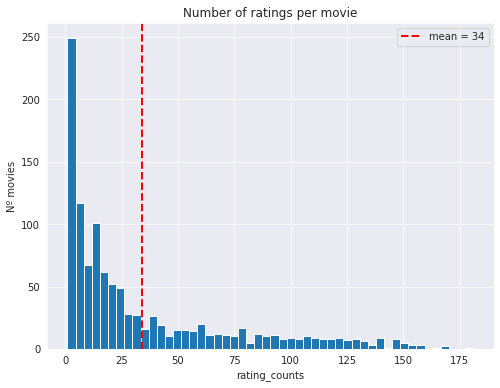

In [11]:
"""
PLOT:

Number of ratings per movie
"""

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('dark')  
%matplotlib inline

mean = int(round(ratings_mean_count['rating_counts'].mean(), 0))
plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True
plt.title("Number of ratings per movie")
plt.xlabel('rating_counts')
plt.ylabel('Nº movies')
plt.axvline(ratings_mean_count['rating_counts'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2, label='mean = ' + str(mean))
ratings_mean_count['rating_counts'].hist(bins=50)  
plt.legend()

In this graph we can see that most of the films have less than 25 ratings, and that few films have more than 50 ratings. With each movie averaging 34 ratings.

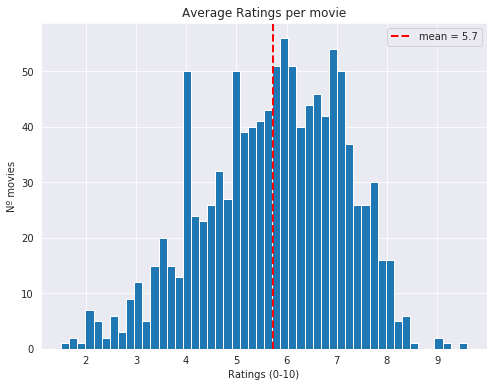

In [12]:
"""
PLOT:

Average ratings per movie
"""
mean = round(ratings_mean_count['rating'].mean(), 1)
plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True
plt.title("Average Ratings per movie")
plt.xlabel('Ratings (0-10)')
plt.ylabel('Nº movies')
plt.axvline(ratings_mean_count['rating'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2, label='mean = ' + str(mean))
ratings_mean_count['rating'].hist(bins=50)
plt.legend()

Here we can see the normal distribution of the ratings, with a mean of around 5.7.

<Figure size 576x432 with 0 Axes>

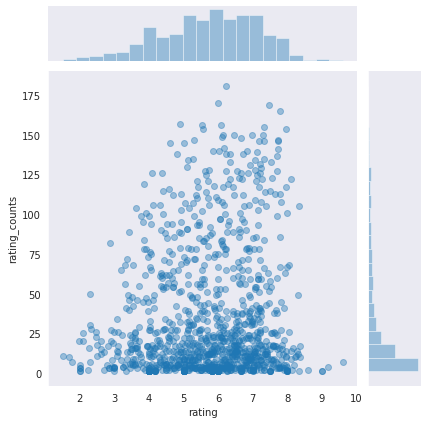

In [13]:
"""
PLOT:

Average ratings against number of ratings per movie
"""

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)  

Here we can see the last two charts in one, where we conclude that movies with a rating lower or near the average of ratings, have a lower number of ratings given, and movies with higher ratings, have a higher number of ratings.

# Experimental Setup and Obtained Results
## Recommender Systems

###  1. BINARY

In [14]:
from recommender_systems import Binary
binary = Binary(reviews, reviews_rs, critic_uid)

### a) Popularity:
Returns the movie with the most reviews.

In [15]:
# Top 1 Movies Recommendation
binary.binary_popularity_based(1)

id
1136    181
Name: rating, dtype: int64

In [16]:
# Top 2 Movies Recommendation
binary.binary_popularity_based(2)

id
1136    181
1071    170
Name: rating, dtype: int64

In [17]:
# Top 5 Movies Recommendation
binary.binary_popularity_based(5)

id
1136    181
1071    170
1704    169
1525    165
1325    157
Name: rating, dtype: int64

### b) Association Rules:


In [18]:
df = binary.ar_create_df()
df.head()

,3,5,6,8,10,13,14,15,17,19,...,1987,1991,1992,1993,1995,1996,1997,1998,1999,2000
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,False,True,False,False,...,True,True,True,True,False,False,True,False,True,True
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
frequent_itemsets = binary.frequent_itemsets(df, min_support=0.03, verbose=0)
frequent_itemsets

,support,itemsets
0,0.043659,(3)
1,0.060291,(23)
2,0.034511,(26)
3,0.031185,(40)
4,0.052391,(57)
5,0.054886,(65)
6,0.057796,(77)
7,0.040748,(95)
8,0.033680,(99)
9,0.039085,(108)


In [20]:
binary.association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(57),(1136),0.052391,0.073181,0.031601,0.603175,8.242244,0.027767,2.335584
1,(301),(1935),0.049064,0.059044,0.030769,0.627119,10.621270,0.027872,2.523474
2,(1935),(301),0.059044,0.049064,0.030769,0.521127,10.621270,0.027872,1.985777
3,(610),(338),0.051143,0.063617,0.030769,0.601626,9.456932,0.027516,2.350511
4,(1017),(338),0.056965,0.063617,0.030353,0.532847,8.375793,0.026729,2.004444
5,(1722),(338),0.056965,0.063617,0.030769,0.540146,8.490530,0.027145,2.036260
6,(841),(443),0.059459,0.057380,0.034096,0.573427,9.993412,0.030684,2.209747
7,(443),(841),0.057380,0.059459,0.034096,0.594203,9.993412,0.030684,2.317761
8,(443),(1071),0.057380,0.068607,0.030769,0.536232,7.815986,0.026833,2.008316
9,(443),(1844),0.057380,0.052807,0.030353,0.528986,10.017403,0.027323,2.010964


### c) Collaborative Filtering:
Based on: 
* https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

In [21]:
# Top 5 Movies Recommendation for movie_id = 3
binary.binary_collab_item_based(3, 5)

Top 5 movie recommendation based on movie_id = 3:
movie_id: 3 with similarity: 1.0
movie_id: 1646 with similarity: 0.132
movie_id: 188 with similarity: 0.13
movie_id: 1136 with similarity: 0.124
movie_id: 23 with similarity: 0.122
movie_id: 1083 with similarity: 0.119


In [22]:
# Top 5 Movies Recommendation for user 'PJ Nabarro'
binary.binary_collab_user_based('PJ Nabarro', 5)

Top 5 movie recommendation based on critic_id = PJ Nabarro:
movie_id: 1110 with similarity: 0.026
movie_id: 821 with similarity: 0.026
movie_id: 968 with similarity: 0.011
movie_id: 810 with similarity: 0.011
movie_id: 1172 with similarity: 0.011


###  2. NON-BINARY

In [23]:
from recommender_systems import NonBinary
non_binary = NonBinary(reviews, reviews_rs, critic_uid, critics)

### a) Popularity:
Returns the movie with the best average rating.

In [24]:
# Top 5 Movies Recommendation
non_binary.nbinary_popularity_based(2)

id
953    9.595238
368    9.166667
Name: rating, dtype: float64

### b) Association Rules:


### c) Collaborative Filtering:

Using surprise package and method SVD++

Based on: 
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp

In [25]:
non_binary.nb_collaborative_filtering(100, 5)

Review range: 0.0 to 10.0
Top movie for reviewer 100: Kimberly Gadette
movie_id: 1418 with predicted rating: 8.17560274661187
movie_id: 1777 with predicted rating: 8.276762823979848
movie_id: 524 with predicted rating: 8.252023294269609
movie_id: 953 with predicted rating: 8.451050244088261
movie_id: 1976 with predicted rating: 8.401420875107313


### 3. Context-Aware Recommendation
For context aware we decided to use information about genre to improve our previous recommendations.
Based on:
* https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

# Conclusions, shortcomings and future work

# References

* https://hackernoon.com/popularity-based-song-recommendation-system-without-any-library-in-python-12a4fbfd825e?gi=3c12b77c73f2
* https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
* https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
* https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp
* https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243